# Planet 

## 1. Initial exploration

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.sgdr import *
from fastai.dataset import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.plots import *

In [43]:
PATH = '../data/Planet/'
os.listdir(PATH)

['train-jpg',
 'test-jpg-additional',
 'train-jpg.tar.7z',
 'train_v2.csv.zip',
 'test-jpg.tar.7z',
 'sub.csv',
 'models',
 'test-jpg',
 'test-jpg-additional.tar',
 'train-jpg.tar',
 'test-jpg-additional.tar.7z',
 '__MACOSX',
 'train_v2.csv',
 'tmp',
 'test-jpg.tar']

In [5]:
labelName = f'{PATH}train_v2.csv'

In [6]:
labels = pd.read_csv(labelName)
labels.head(),labels.shape

(  image_name                                       tags
 0    train_0                               haze primary
 1    train_1            agriculture clear primary water
 2    train_2                              clear primary
 3    train_3                              clear primary
 4    train_4  agriculture clear habitation primary road, (40479, 2))

In [26]:
imgs = os.listdir(f'{PATH}train-jpg')[:5];imgs

['train_23452.jpg',
 'train_14536.jpg',
 'train_32056.jpg',
 'train_32349.jpg',
 'train_23536.jpg']

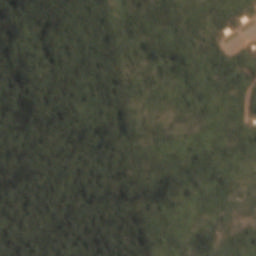

In [30]:
img = PIL.Image.open(f'{PATH}train-jpg/{imgs[4]}').convert('RGB');img

In [31]:
img.size

(256, 256)

## 2. Initial architecture, evaluation metrics and data

In [7]:
val_idxs = get_cv_idxs(labels.shape[0]);val_idxs[:5]

array([34602, 11243, 14499, 18918, 30631])

In [30]:
from sklearn.metrics import fbeta_score
arch = resnet34
sz = 64
bs = 64

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])
    

def get_data(sz,bs):
    tfms = tfms_from_model(arch,sz,aug_tfms=transforms_top_down,max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train-jpg',labelName,bs=bs, tfms = tfms, val_idxs = val_idxs,
                                       suffix='.jpg',test_name = 'test-jpg')
    return data

data = get_data(sz,bs)


## 3. Training model

In [31]:
learn = ConvLearner.pretrained(arch,data,metrics=[f2])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 20%|██        | 103/506 [00:08<00:32, 12.57it/s, loss=0.843]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f2                          
    0      0.221799   0.31386    0.83106   



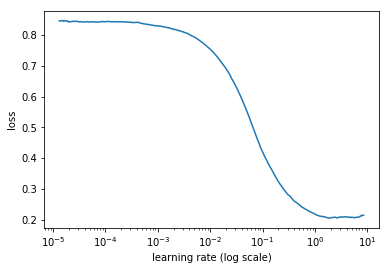

In [18]:
learn.lr_find()
learn.sched.plot()

In [20]:
lr = 0.2
learn.fit(lr,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.144105   0.132216   0.884268  
    1      0.14172    0.12674    0.891193                    
    2      0.13631    0.124571   0.892119                    



[0.124570504, 0.8921194462184321]

In [21]:
learn.save(f'{sz}_1')

In [22]:
learn.load(f'{sz}_1')
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
%time learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.118251   0.105773   0.91039   
    1      0.112194   0.100223   0.91669                     
    2      0.103662   0.097233   0.919253                    
    3      0.110556   0.101364   0.913738                    
    4      0.099285   0.097518   0.91999                      
    5      0.101488   0.094549   0.920986                     
    6      0.097714   0.093903   0.921992                     

CPU times: user 18min 48s, sys: 2min 34s, total: 21min 22s
Wall time: 10min 27s


[0.0939026, 0.9219920553992527]

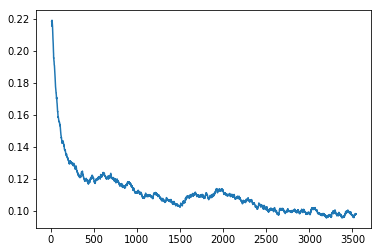

In [23]:
learn.sched.plot_loss()

In [24]:
learn.save(f'{sz}_2')

In [32]:
learn.load(f'{sz}_2')
sz = 128
learn.set_data(get_data(sz,64))
learn.freeze()
%time learn.fit(lr,3, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.099091   0.093807   0.920945  
    1      0.094278   0.092858   0.921092                     
    2      0.095451   0.092654   0.921486                     

CPU times: user 9min 26s, sys: 1min 4s, total: 10min 30s
Wall time: 3min 38s


[0.09265359, 0.9214855460189217]

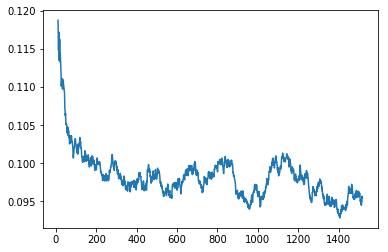

In [33]:
learn.sched.plot_loss()

In [34]:
learn.save(f'{sz}_1')

In [35]:
learn.load(f'{sz}_1')
learn.unfreeze()
%time learn.fit(lrs,3, cycle_len=1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.094455   0.088192   0.925862  
    1      0.095011   0.088399   0.926935                     
    2      0.090206   0.085605   0.928021                     
    3      0.095698   0.088235   0.927168                     
    4      0.088694   0.086647   0.92695                      
    5      0.085717   0.085714   0.928059                     
    6      0.084606   0.084459   0.929637                     

CPU times: user 31min 57s, sys: 4min 51s, total: 36min 48s
Wall time: 21min 40s


[0.08445932, 0.9296365219555535]

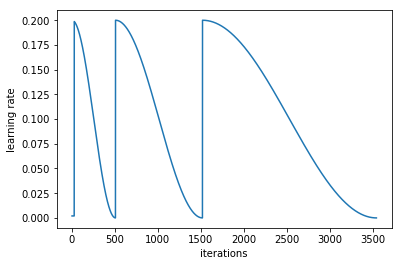

In [36]:
learn.sched.plot_lr()

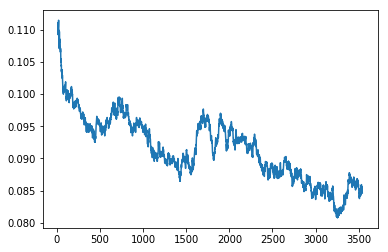

In [37]:
learn.sched.plot_loss()

In [38]:
learn.save(f'{sz}_2')

In [39]:
learn.load(f'{sz}_2')
sz = 256
learn.set_data(get_data(sz,64))
learn.freeze()
%time learn.fit(lr,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.092298   0.089872   0.923875  
    1      0.091161   0.089595   0.92441                      
    2      0.090476   0.088405   0.925684                     

CPU times: user 24min 31s, sys: 4min 25s, total: 28min 57s
Wall time: 14min 41s


[0.08840518, 0.9256844070664951]

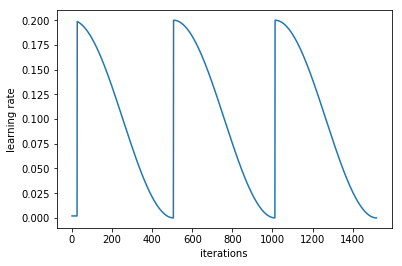

In [40]:
learn.sched.plot_lr()

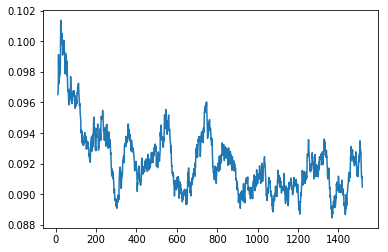

In [41]:
learn.sched.plot_loss()

In [42]:
learn.save(f'{sz}_1')

In [43]:
learn.load(f'{sz}_1')
learn.unfreeze()
%time learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.08616    0.083777   0.930222  
    1      0.089242   0.085716   0.927301                     
    2      0.085968   0.08231    0.930991                     
    3      0.088404   0.085994   0.929053                     
    4      0.087108   0.083779   0.930329                     
    5      0.080937   0.082529   0.929938                     
    6      0.080132   0.081592   0.932083                     

CPU times: user 1h 30min 50s, sys: 19min 12s, total: 1h 50min 2s
Wall time: 1h 20min 40s


[0.08159228, 0.9320833509644594]

In [44]:
learn.save(f'{sz}_2')

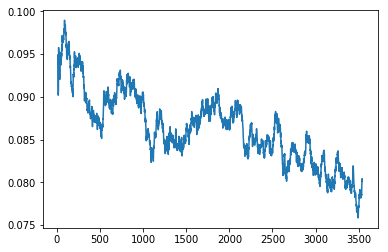

In [45]:
learn.sched.plot_loss()

In [46]:
pred_log,y = learn.TTA()

In [49]:
pred_log_m = np.mean(pred_log,0);pred_log_m.shape

(8095, 17)

In [52]:
f2(pred_log_m,y)

0.9307168509667758

## 4. Utilize the model to predict the test data

### 4.1 Find the optimize threshold

In [ ]:
def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

ths = opt_th(pred_log_m, y)

### 4.2 Predict test image with test time augmentation

In [34]:
learn.load('256_2')
y_pred_test, y = learn.TTA(is_test = True)

In [35]:
y_pred_test_m = np.mean(y_pred_test,0)

In [36]:
y_pred_test_m.shape

(61191, 17)

### 4.3 Create submission csv by pandas data frame

In [ ]:
fnames = learn.data.test_ds.fnames

In [19]:
data.test_ds.fnames[:3]

['test-jpg/test_25202.jpg',
 'test-jpg/test_5717.jpg',
 'test-jpg/test_40598.jpg']

In [37]:
fnames = [fname[9:-4] for fname in data.test_ds.fnames];len(fnames)

61191

In [44]:
sub = pd.DataFrame(columns=['image_name','tags'])
for i in range(y_pred_test_m.shape[0]): 
    tags = ''
    for j in range(y_pred_test_m.shape[1]):
         if y_pred_test_m[i][j] > ths:
                tags = tags + data.classes[j] + ' '
    sub = sub.append({'image_name':fnames[i], 'tags':tags}, ignore_index=True)

In [42]:
sub_path = f'{PATH}sub.csv'
sub.to_csv(sub_path,index=False)
FileLink(sub_path)

/home/paperspace/practice/data/Planet/sub.csv